# Orienting a detector relative to the DM wind

The DM wind velocity (vW = -vLab) in the lab frame originates from a point on the sky, close to the constellation Cygnus, near galactic coordinates (l,b)=(90,0). Where is this point, precisely, relative to a lab on Earth?

In [1]:
import numpy as np
import sys
import math
import datetime as dts #for calendar functions
from astropy.coordinates import SkyCoord, Galactic, ICRS
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body
from astropy.coordinates import CartesianRepresentation, CartesianDifferential

import matplotlib.pyplot as plt
# import matplotlib.colors as clr

# sys.path.insert(0,'../') #load the local version
from earthspeed import *


### Example: Using vEt_precise and datetime

In [2]:
# 

nDays = 185.7537

date_ref = dts.datetime(2024, 5, 30, 5, 28, 0)
date = date_ref + dts.timedelta(days=nDays)
print(date)

print(vEt_sincemax(nDays)/km_s)
print(np.linalg.norm(vEt_sincemax(nDays))/km_s)

2024-12-01 23:33:19.680000
[  3.39277097 234.96633789  32.22805137]
237.1905102040295


Note that calling datetime.now() without a timezone specifier usually reverts to the local time.

In [3]:
print(dts.datetime.now())
print(dts.datetime.now(dts.timezone.utc))

2024-08-14 17:18:49.164266
2024-08-15 00:18:49.164342+00:00


In [4]:
# Example: altitude and azimuth for a particular place on Earth

date = dts.datetime.now(dts.timezone.utc)
wind = Windfinder([date])
print('Example datetime (UTC):', date)
ra, dec = wind.RAdec[0]
print('Sky position: RA, dec [deg] = ({:.2f}, {:.2f})'.format(ra, dec))

labplace = EarthLocation(lat='44.0459', lon='-123.07245', height=0.*u.m)
altaz = wind.vE_altAz(labplace)
print('Willamette Hall, U.Oregon:')
print('\t vE [km/s]: {:.2f} \t alt [deg]: {:.2f} \t az [deg]: {:.2f}'.format(altaz[0][0], altaz[0][1], altaz[0][2]))

# Can also use astropy object Windfinder.galactic directly:
vE_icrs = wind.galactic[0].transform_to(ICRS())
vE_icrs.dec

Example datetime (UTC): 2024-08-15 00:18:49.478224+00:00
Sky position: RA, dec [deg] = (323.09, 49.27)
Willamette Hall, U.Oregon:
	 vE [km/s]: 256.49 	 alt [deg]: 18.03 	 az [deg]: 37.29


<Latitude 49.26714656 deg>

In [5]:
# Example: sky coordinate for v_Sun (rather than v_Earth)

wind = Windfinder([date], at_Sun=True)
print('Example datetime (UTC):', date)
ra, dec = wind.RAdec[0]
print('Sky position (v_Sun): RA, dec [deg] = ({:.2f}, {:.2f})'.format(ra, dec))

sun_RAdec = np.array([ra, dec])

Example datetime (UTC): 2024-08-15 00:18:49.478224+00:00
Sky position (v_Sun): RA, dec [deg] = (313.62, 47.54)


In [6]:
# Example: for the Earth, but with a different value of vCirc (220 km/s)

wind = Windfinder([date], vCirc=220*km_s)
print('Example datetime (UTC):', date)
ra, dec = wind.RAdec[0]
print('Sky position: RA, dec [deg] = ({:.2f}, {:.2f})'.format(ra, dec))



Example datetime (UTC): 2024-08-15 00:18:49.478224+00:00
Sky position: RA, dec [deg] = (323.48, 49.33)


## Daily Variation: Altitude and Azimuth at a specific location

Taking the example of Chicago, IL, USA, during daylight savings time (CDT). This demo uses the vE_AltAz function from earthspeed.

In [7]:
cdt = dts.timezone(dts.timedelta(hours=-5), name='CDT')
midnight = dts.datetime(2024, 8, 12, hour=0, tzinfo=cdt)
midnight.astimezone(dts.timezone.utc)

datetime.datetime(2024, 8, 12, 5, 0, tzinfo=datetime.timezone.utc)

In [8]:
dt_hours = 0.25
dt = dt_hours * dts.timedelta(hours=1)
obstimes = [midnight + dt * j for j in range(24*4+1)]
location = EarthLocation(lat='41.8', lon='-88.3', height=0.*u.m)

tH = np.zeros(len(obstimes))
vEs = np.zeros(len(obstimes))
alts = np.zeros(len(obstimes))
azs = np.zeros(len(obstimes))

for j,time in enumerate(obstimes):
    vE, alt, az = vE_AltAz(time, location)
    tH[j] = dt_hours*j 
    vEs[j] = vE
    alts[j] = alt
    azs[j] = az

print('altitude min and max [degrees]:', alts.min(), alts.max())

#

altitude min and max [degrees]: 0.9541513218038213 82.68858157280859


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_29214/2239178997.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


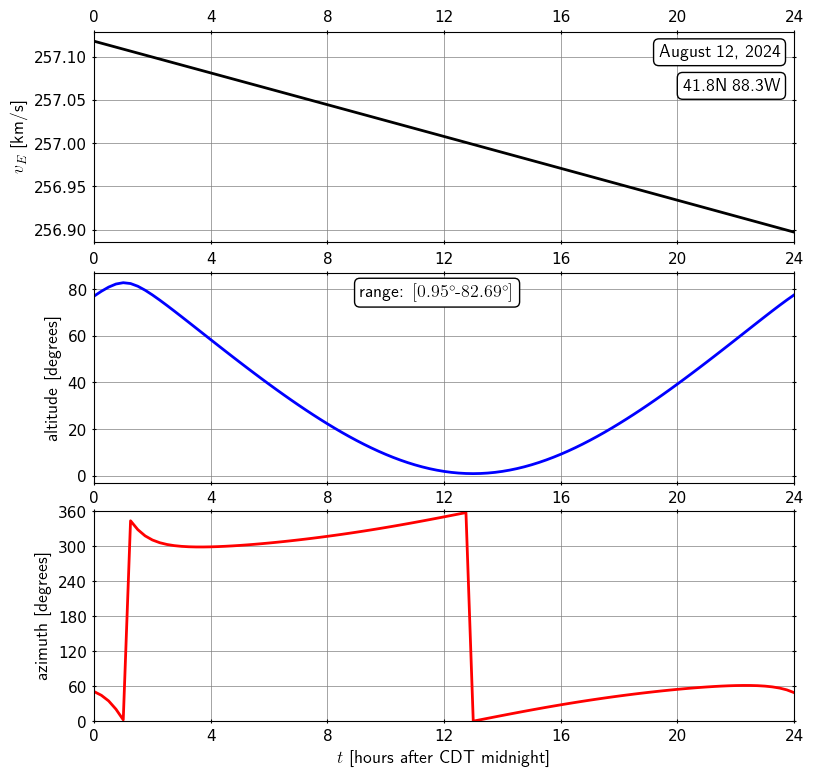

In [9]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,unisize])
xlim = [0, 24]

xtix = [4*j for j in range(7)]

ax = fig.add_axes([0,0,1,0.6], xscale='linear', yscale='linear')
ax.set_xticks(xtix)
ax.set_xlim(xlim)
ax.set_yticks([60*j for j in range(7)])
ax.set_ylim([0, 360])
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True, labelbottom=True, labeltop=False)
ax.set_xlabel(r'$t$ [hours after CDT midnight]', fontsize=13, usetex=True)
ax.set_ylabel(r'azimuth [degrees]', 
              fontsize=13, usetex=True)

ax.plot(tH, azs, color='red', linewidth=2, linestyle='solid')
ax.grid(color='gray', linestyle='-', linewidth=0.5)

ax2 = fig.add_axes([0,0.68,1,0.6], xscale='linear', yscale='linear')
ax2.set_xticks(xtix)
ax2.set_xlim(xlim)
ax2.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=True, labeltop=True)
ax2.set_ylabel(r'altitude [degrees]', 
               fontsize=13, usetex=True)
ax2.plot(tH, alts, color='blue', linewidth=2, linestyle='solid')
ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3 = fig.add_axes([0,1.37,1,0.6], xscale='linear', yscale='linear')
ax3.set_xticks(xtix)
ax3.set_xlim(xlim)
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=False, labeltop=True)
ax3.set_ylabel(r'$v_E$ [km/s]', 
               fontsize=13, usetex=True)
ax3.plot(tH, vEs, color='black', linewidth=2, 
         linestyle='solid')
ax3.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.text(0.49, 0.95, r'range: $[{:.2f}^\circ$-${:.2f}^\circ]$'.format(alts.min(), alts.max()), 
         horizontalalignment='center',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax2.transAxes, usetex=True)

ax3.text(0.98, 0.94, r'August 12, 2024', 
         horizontalalignment='right',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax3.transAxes, usetex=True)

ax3.text(0.98, 0.78, r'41.8N 88.3W', 
         horizontalalignment='right',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax3.transAxes, usetex=True)


fig.show() 



# Annual Variation: Boosted Lab Frame 

Using vEt_precise to find vEarth(t) in km/s, then mapping this vector to a point on the sphere. 



## Routine for calculating annual variations in speed, right ascension, and declination

In [10]:
ny_2024 = dts.datetime.fromisoformat('2024-01-01T00:00:00')


vCircs = [220, 230, 238]

days = [n for n in range(0, 366)]
obstimes = []
for n in days:
    obstimes += [ny_2024 + dts.timedelta(days=n)]


d_ras = {}
d_decs = {}
d_speeds = {}

for vCirc in vCircs:
    wind = Windfinder(obstimes, vCirc=vCirc*km_s)
    RAdec = wind.RAdec 
    d_ras[vCirc] = RAdec[:, 0]
    d_decs[vCirc] = RAdec[:,1]
    d_speeds[vCirc] = wind.speed
    
days = np.array(days)

In [11]:
# Labels for months (n for the first day of each month)

mo_n = []

for mo in range(1, 13):
    first = dts.datetime(2024, mo, 1, 0, 0)
    delta = first - ny_2024
    n_mo = delta.days
    mo_n += [n_mo]

mo = 13
first = dts.datetime(2025, 1, 1, 0, 0)
delta = first - ny_2024
n_mo = delta.days
mo_n += [n_mo]

mo_n = np.array(mo_n)

mo_names = ['Jan 24', 'Feb', 'March', 'April', 
            'May', 'June', 'July', 'Aug', 
            'Sept', 'Oct', 'Nov', 'Dec', 'Jan 25']

# Plots

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_29214/2544125233.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


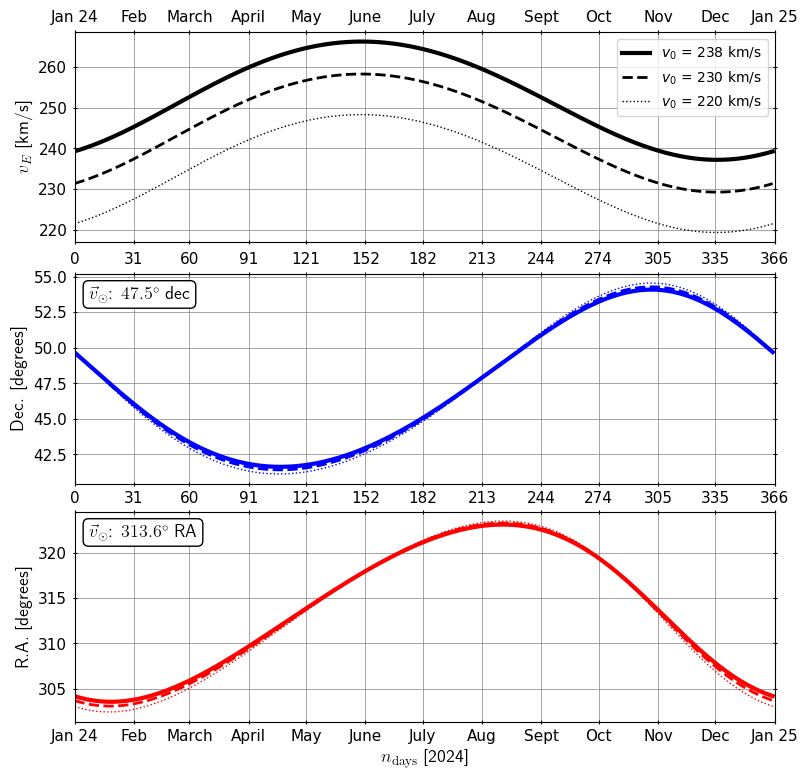

In [12]:
unisize = 3.5
fig = plt.figure(figsize=[2.0*unisize,unisize])
xlim = [0, 366]

# xtix = [30*j for j in range(13)]
xtix = mo_n

ax = fig.add_axes([0,0,1,0.6], xscale='linear', yscale='linear')
ax.set_xticks(xtix, labels=mo_names)
ax.set_xlim(xlim)
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True, labelbottom=True, labeltop=False)
ax.set_xlabel(r'$n_{\rm days}$ [2024]', fontsize=13, usetex=True)
ax.set_ylabel(r'R.A. [degrees]', 
              fontsize=13, usetex=True)

ax.plot(days, d_ras[238], color='red', linewidth=3, linestyle='solid')
ax.plot(days, d_ras[230], color='red', linewidth=2, linestyle='dashed')
ax.plot(days, d_ras[220], color='red', linewidth=1, linestyle='dotted')
# ax.set_ylim([3e-4, 3])
ax.grid(color='gray', linestyle='-', linewidth=0.5)

ax2 = fig.add_axes([0,0.68,1,0.6], xscale='linear', yscale='linear')
ax2.set_xticks(xtix)
ax2.set_xlim(xlim)
ax2.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=True, labeltop=True)
ax2.set_ylabel(r'Dec. [degrees]', 
               fontsize=13, usetex=True)
ax2.plot(days, d_decs[238], color='blue', linewidth=3, linestyle='solid')
ax2.plot(days, d_decs[230], color='blue', linewidth=2, linestyle='dashed')
ax2.plot(days, d_decs[220], color='blue', linewidth=1, linestyle='dotted')
ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3 = fig.add_axes([0,1.37,1,0.6], xscale='linear', yscale='linear')
ax3.set_xticks(xtix, labels=mo_names)
ax3.set_xlim(xlim)
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True, labelbottom=False, labeltop=True)
ax3.set_ylabel(r'$v_E$ [km/s]', 
               fontsize=13, usetex=True)
ax3.plot(days, d_speeds[238], color='black', linewidth=3, 
         linestyle='solid', label=r'$v_0$ = 238 km/s')
ax3.plot(days, d_speeds[230], color='black', linewidth=2, 
         linestyle='dashed', label=r'$v_0$ = 230 km/s')
ax3.plot(days, d_speeds[220], color='black', linewidth=1, 
         linestyle='dotted', label=r'$v_0$ = 220 km/s')
ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.legend()

ax.text(0.02, 0.94, r'$\vec{v}_\odot$: $313.6^\circ$ RA', 
        horizontalalignment='left',
        verticalalignment='top', fontsize=13, 
        color='black', backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax2.text(0.02, 0.94, r'$\vec{v}_\odot$: $47.5^\circ$ dec', 
         horizontalalignment='left',
         verticalalignment='top', fontsize=13, 
         color='black', backgroundcolor='white',
         bbox=dict(boxstyle='round', fc='w'),
         transform=ax2.transAxes, usetex=True)


fig.show() 



### With right ascension in hours rather than degrees:

In [13]:
mo_ras = {}
mo_decs = {}
sun_RAdec = {}

for vCirc in vCircs:
    mo_ras[vCirc] = np.array([d_ras[vCirc][j] for j in mo_n[0:-1]])
    mo_decs[vCirc] = np.array([d_decs[vCirc][j] for j in mo_n[0:-1]])

    wind = Windfinder([date], vCirc=vCirc*km_s, at_Sun=True)
    sun_RAdec[vCirc] = wind.RAdec[0]

#

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_29214/3859274210.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


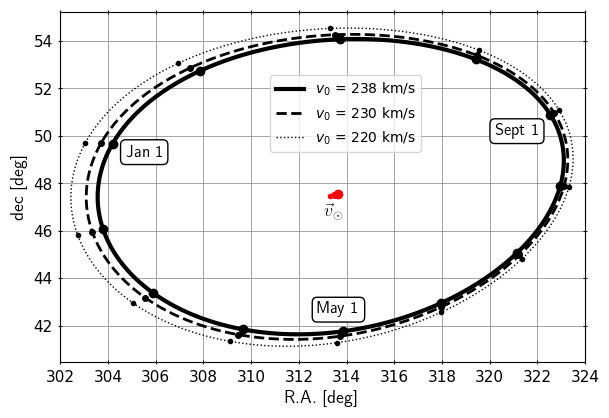

In [14]:
unisize = 3.5
fig = plt.figure(figsize=[1.5*unisize,unisize])

xtix = [j for j in range(300, 326, 2)]

ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')

ax.set_xticks(xtix)
ax.set_xlim([302, 324])
# ax.set_yticks(np.array([20 + 0.25*j for j in range(13)]))
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True, labelbottom=True, labeltop=False)
ax.set_xlabel(r'R.A. [deg]', fontsize=13, usetex=True)
ax.set_ylabel(r'dec [deg]', fontsize=13, usetex=True)

ax.plot(d_ras[238], d_decs[238], color='black', linewidth=3, 
        linestyle='solid', label=r'$v_0$ = 238 km/s')
ax.plot(d_ras[230], d_decs[230], color='black', linewidth=2, 
        linestyle='dashed', label=r'$v_0$ = 230 km/s')
ax.plot(d_ras[220], d_decs[220], color='black', linewidth=1, 
        linestyle='dotted', label=r'$v_0$ = 220 km/s')
ax.grid(color='gray', linestyle='-', linewidth=0.5)


ax.plot([sun_RAdec[238][0]], [sun_RAdec[238][1]], color='red', marker='o')
ax.plot(mo_ras[238], mo_decs[238], color='black', marker='o', linestyle='none')

ax.plot([sun_RAdec[230][0]], [sun_RAdec[230][1]], color='red', 
        marker='o', markersize=4)
ax.plot(mo_ras[230], mo_decs[230], color='black', marker='o', 
        linestyle='none', markersize=4)

ax.plot([sun_RAdec[220][0]], [sun_RAdec[220][1]], color='red', 
        marker='o', markersize=3)
ax.plot(mo_ras[220], mo_decs[220], color='black', marker='o', 
        linestyle='none', markersize=3)


ax.text(0.52, 0.43, r'$\vec{v}_\odot$', 
        horizontalalignment='center',
        verticalalignment='center', fontsize=13, 
        color='black', 
        # backgroundcolor='white',
        # bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax.text(0.16, 0.6, r'Jan 1', 
        horizontalalignment='center',
        verticalalignment='center', fontsize=12, 
        color='black', 
        backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax.text(0.53, 0.15, r'May 1', 
        horizontalalignment='center',
        verticalalignment='center', fontsize=12, 
        color='black', 
        backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax.text(0.87, 0.66, r'Sept 1', 
        horizontalalignment='center',
        verticalalignment='center', fontsize=12, 
        color='black', 
        backgroundcolor='white',
        bbox=dict(boxstyle='round', fc='w'),
        transform=ax.transAxes, usetex=True)

ax.legend(loc=(0.4, 0.6))



fig.show() 

